In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# The Teapot

First we define a function that allows us to load in an image.

In [3]:
import matplotlib.image as mpimg
from scipy.ndimage import convolve

In [4]:
def load_image(path):
    return mpimg.imread(path)

In [5]:
def plot_image(img):
    plt.imshow(teapot)

In [6]:
def plot_image_bw(img):
    plt.imshow(img, cmap=plt.get_cmap('gray'))

Load in an iconic image of a teapot.

In [7]:
image_teapot = "teapot.jpeg"

In [8]:
teapot = load_image(image_teapot)

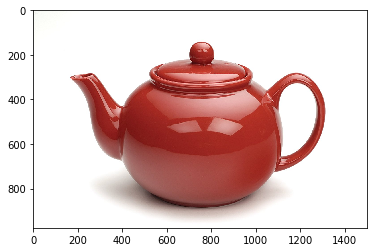

In [9]:
plot_image(teapot)

We can see that the dimension of image of the teapot is $977 \times 1500$ with three channels for $(r, g, b)$.

In [10]:
teapot.shape

(977, 1500, 3)

First we want to transform the color image to a greyscale image. This is done with the formula:

$$ Y' = 0.2989R + 0.5870G + 0.1140B $$

In [11]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

Applying this to the teapot:

In [12]:
teapot_bw = rgb2gray(teapot)

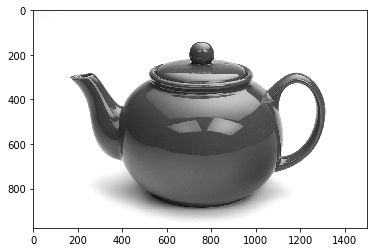

In [13]:
plot_image_bw(teapot_bw)

Which results in an image with dimension:

In [14]:
teapot_bw.shape

(977, 1500)

Because the pixel is now a single value, and not a 3-component $RGB$ vector, we can now apply a convulation.

# Guassian Smoothing

The Guassian smoothing operator is a 2D convulation kernel.

In [15]:
gaussian_kernel = 1 / 272 * np.matrix([1,4,7,4,1,4,16,26,16,4,7,26,41,26,7,4,16,26,16,4,1,4,7,4,1]).reshape((5,5))
gaussian_kernel

matrix([[0.00367647, 0.01470588, 0.02573529, 0.01470588, 0.00367647],
        [0.01470588, 0.05882353, 0.09558824, 0.05882353, 0.01470588],
        [0.02573529, 0.09558824, 0.15073529, 0.09558824, 0.02573529],
        [0.01470588, 0.05882353, 0.09558824, 0.05882353, 0.01470588],
        [0.00367647, 0.01470588, 0.02573529, 0.01470588, 0.00367647]])

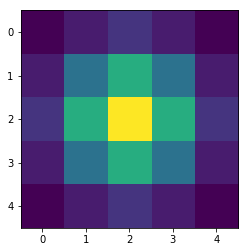

In [16]:
plt.imshow(gaussian_kernel)

In [17]:
teapot_bw_smooth = convolve(teapot_bw, gaussian_kernel)

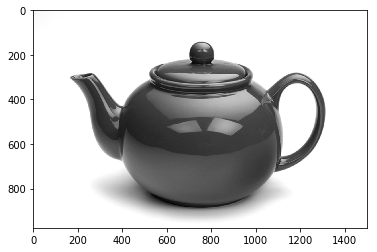

In [18]:
plot_image_bw(teapot_bw_smooth)

# 2D Spatial Gradient Measurement

In [19]:
Gx = np.matrix([[1, 0], [0, -1]])
Gy = np.matrix([[0, 1], [-1, 0]])

In [20]:
grad_x = convolve(teapot_bw, Gx)

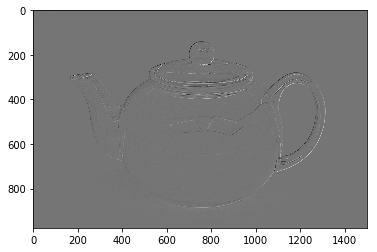

In [21]:
plot_image_bw(grad_x)

In [22]:
grad_y = convolve(teapot_bw, Gy)

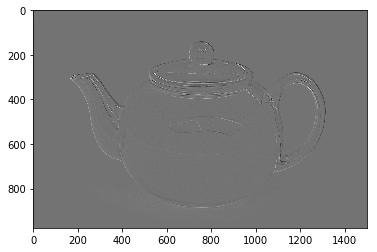

In [23]:
plot_image_bw(grad_y)

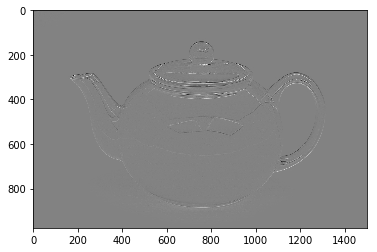

In [24]:
plot_image_bw(grad_x + grad_y)

# Sobel Operator

In [25]:
Gx = np.matrix([[-1, 0, 1], [-2,.0, 2], [-1, 0 ,1]])
Gy = np.flip(Gx.T)

In [26]:
sobel_x = convolve(teapot_bw, Gx)
sobel_y = convolve(teapot_bw, Gy)

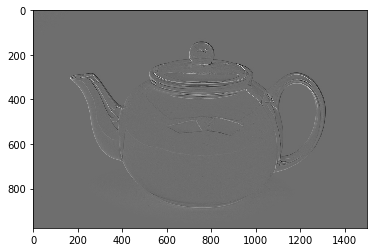

In [27]:
plot_image_bw(sobel_x + sobel_y)

In [28]:
smooth_sobel = convolve(sobel_x + sobel_y, gaussian_kernel)

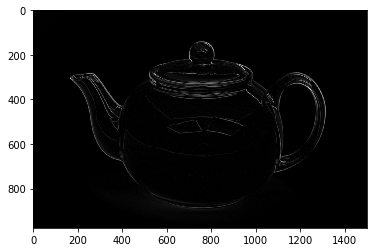

In [29]:
plot_image_bw(np.abs(smooth_sobel))

# Canny Edge Detector

In [30]:
T1 = 0.2
T2 = 0.99
teapot_grad = sobel_x + sobel_y
teapot_grad_norm = teapot_grad / 255
teapot_grad_norm_smooth = convolve(teapot_grad_norm, gaussian_kernel)
teapot_threshold = np.vectorize(lambda x: 1 if T1 < abs(x) < T2 else 0)(teapot_grad_norm_smooth)

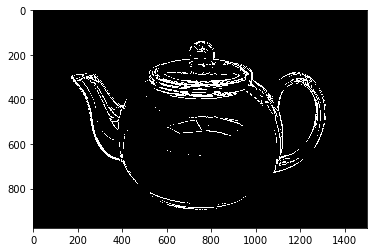

In [31]:
plot_image_bw(teapot_threshold * 255)

The steps performed for the Canny edge detector are:

1. Smooth the image using a Gaussian filter to remove high frequency noise.
2. Compute the gradient intensity representation of the image.
3. Apply non-maximum supression to remove "false" responses to edge detection.
4. Apply thresholding using a `lower` and `upper` boundary on the gradient values.
5. Track edges using hysteresis by supressing weak edges that are not connected to strong edges.

# Extract Points

In [32]:
P = []
for x in range(teapot_threshold.shape[0]):
    for y in range(teapot_threshold.shape[1]):
        if teapot_threshold[x, y] > 0.1:
            P.append((y, x))

In [33]:
P = sorted(P, key=lambda x: x[0])

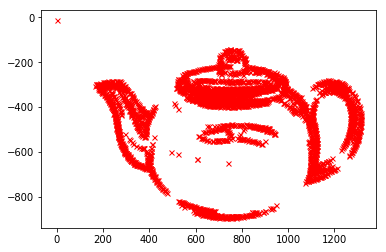

In [34]:
sparsity = 16
x, y = zip(*P[0::sparsity])
plot(x, -np.array(y), 'o', ms=5, c='red', marker='x')

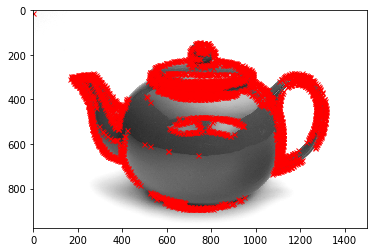

In [35]:
plot_image_bw(teapot_bw)
plt.plot(x, y, 'o', ms=5, c='red', marker='x')

# Convex Hull

This algorithm is already implemented and can be found at the following url:

https://darkeclipz.github.io/compgeo/convex-hull.html

This needs to be reimplemented in Python.

In [36]:
def det2(a, b, c, d):
    return a * d - b * c

In [37]:
def is_right_turn(p1, p2, p3):
    return det2(p1[0] - p2[0], p1[1] - p2[1], p3[0] - p2[0], p3[1] - p2[1]) >= 0

In [38]:
def convex_hull(P):
    n = len(P)
    sorted(P, key=lambda p: p[0])
    L_upper = [P[0], P[1]]
    for i in range(2, n):
        L_upper.append(P[i])
        while len(L_upper) > 2 and not is_right_turn(L_upper[-3], L_upper[-2], L_upper[-1]):
            del L_upper[-2]
    L_lower = [P[-1], P[-2]]
    for i in range(n - 2, 0, -1):
        L_lower.append(P[i])
        while len(L_lower) > 2 and not is_right_turn(L_lower[-3], L_lower[-2], L_lower[-1]):
            del L_lower[-2]
    return L_upper + L_lower

In [39]:
CH = convex_hull(list(zip(x, y)))
del CH[0]
CH.append(CH[0])  # close the loop

In [40]:
chx, chy = zip(*CH)

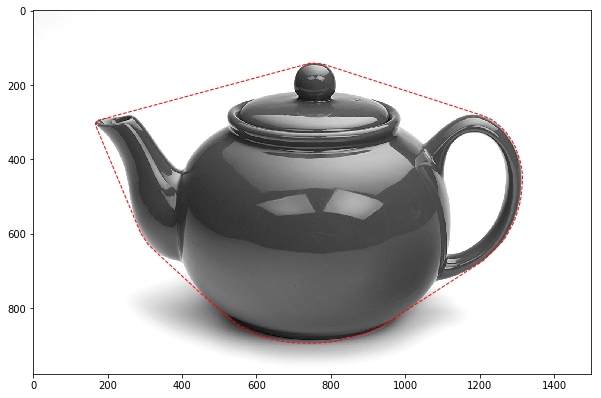

In [41]:
plt.figure(figsize=(10,10))
plot(chx, chy, c='red', lw=1, ls='dashed')
plot_image_bw(teapot_bw)

# Resources

1. http://www.cse.usf.edu/~r1k/MachineVisionBook/MachineVision.files/MachineVision_Chapter5.pdf

2. https://www.pyimagesearch.com/2015/04/06/zero-parameter-automatic-canny-edge-detection-with-python-and-opencv/

3. https://homepages.inf.ed.ac.uk/rbf/HIPR2/gsmooth.htm

4. https://homepages.inf.ed.ac.uk/rbf/HIPR2/canny.htm

5. https://homepages.inf.ed.ac.uk/rbf/HIPR2/roberts.htm